# Annotated Jupyter Notebook: Song Popularity Prediction

## **1. Import Libraries**

- **Purpose**: 
  - `pandas`, `numpy`: For data manipulation and calculations.
  - `matplotlib`, `seaborn`: For visualizing trends and relationships.
  - `RandomForestRegressor`: Machine learning model for regression tasks.
  - `mean_absolute_error`, `mean_squared_error`: Evaluate prediction performance.
  - `train_test_split`: Split data into training and testing subsets.
  - `GridSearchCV`: Perform hyperparameter tuning to optimize machine learning models.
  - `ConfusionMatrixDisplay`: Create confusion matrix for regressio predictions.
  - `XGBClassifier`: Gradient Boosting model for binary or multi-class classification.
  - `streamlit`: Create an interactive web application for your machine learning model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
import streamlit as st

## **2. Load Data**

- **Purpose**: Load the datasets into two dataframes:
  - `spotify_df`: Contains Spotify audio features.
  - `billboard_df`: Contains Billboard chart rankings and metadata.
  - Validate the data structure using:
    ```python
    print(spotify_df.info())
    print(billboard_df.info())
    ```

In [2]:
spotify_df = pd.read_csv('spotify_songs.csv')
billboard_df = pd.read_csv('billboard_data.csv')

In [3]:
print(spotify_df.info())
print(billboard_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

## **3. Data Cleaning**

- **Purpose**:
  - Standardize column names (`track_name` → `Song`, `track_artist` → `Artist`).
  - Merge the two datasets on the `Song` and `Artist` columns to combine features and rankings.
  - Remove rows with missing values using `.dropna()`.
  - Check for duplicates after merging: print(merged_df.duplicated().sum())

In [4]:
spotify_df.rename(columns={'track_name': 'Song', 'track_artist': 'Artist'}, inplace=True)
billboard_df.rename(columns={'title': 'Song', 'artist': 'Artist'}, inplace=True)

In [5]:
merged_df = pd.merge(spotify_df, billboard_df, on=['Song', 'Artist'], how='inner')

In [6]:
merged_df.dropna(inplace=True)

In [7]:
print(merged_df.duplicated().sum())

0


## **4. Data Exploration**

- **Purpose**:
  - Check correlations with heat map.
  - Analyze chart position distributions

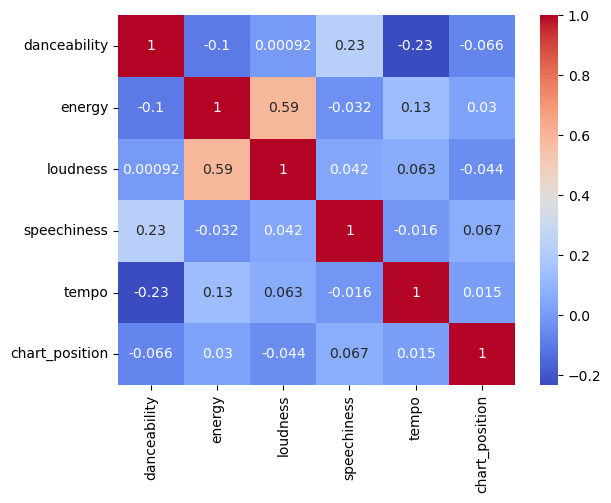

In [8]:
corr = merged_df[['danceability', 'energy', 'loudness', 'speechiness', 'tempo', 'chart_position']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


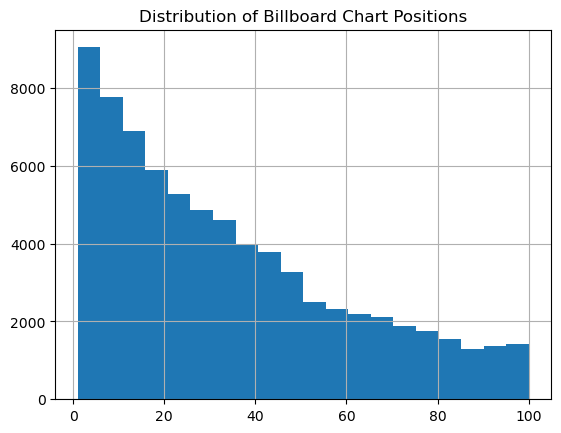

In [9]:
merged_df['chart_position'].hist(bins=20)
plt.title('Distribution of Billboard Chart Positions')
plt.show()


In [10]:
# Define 'top_10': 1 if the song is in the top 10, else 0
merged_df['top_10'] = (merged_df['chart_position'] <= 10).astype(int)

# Verify the new column
print(merged_df['top_10'].value_counts())


top_10
0    56878
1    16792
Name: count, dtype: int64


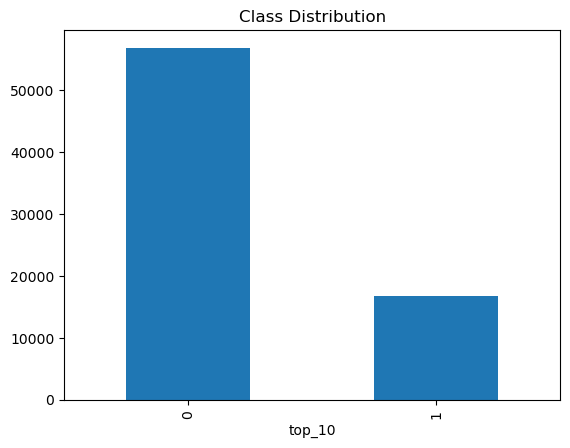

In [11]:
merged_df['top_10'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()


## **5. Model Training**

- **Purpose**:
  - `X`: Features (`tempo`, `danceability`, `loudness`, `energy`).
  - `y`: Target variable (`chart_position`).
  - Split data into training and testing sets (80% training, 20% testing).
  - Train a `RandomForestRegressor` on the training data.

In [13]:
X = merged_df[['danceability', 'energy', 'loudness', 'speechiness', 'tempo']]
y = merged_df['chart_position']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## **6. Model Evaluation**

- **Purpose**:
  - `MAE` (Mean Absolute Error): Measures the average magnitude of errors.
  - `RMSE` (Root Mean Squared Error): Penalizes large errors more heavily.
  - Compare with a baseline model (e.g., mean prediction of `chart_position`).

In [15]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 15.358080099286248
RMSE: 19.61444592043877


In [16]:
baseline_prediction = y_test.mean()
baseline_predictions = np.full_like(y_test, baseline_prediction)

In [17]:
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)


Baseline MAE: 21.423170897244468
Baseline RMSE: 25.96265630080185


In [18]:
model_mae = mean_absolute_error(y_test, y_pred)
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest MAE:", model_mae)
print("Random Forest RMSE:", model_rmse)

print("Improvement in MAE:", baseline_mae - model_mae)
print("Improvement in RMSE:", baseline_rmse - model_rmse)


Random Forest MAE: 15.358080099286248
Random Forest RMSE: 19.61444592043877
Improvement in MAE: 6.06509079795822
Improvement in RMSE: 6.348210380363081


## **7. Tune Hyperparameters**

- **Purpose**:
  - `GridSearchCV` to optimize the classifier or regressor.
  - `ConfusionMatrixDisplay` to visualize regression predictions vs. actual values.

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Make Predictions
y_pred = classifier.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.026605130989547983
              precision    recall  f1-score   support

           1       0.03      0.04      0.03       366
           2       0.00      0.00      0.00       322
           3       0.03      0.92      0.05       392
           4       0.03      0.04      0.04       335
           5       0.00      0.00      0.00       332
           6       0.00      0.00      0.00       332
           7       0.00      0.00      0.00       318
           8       0.00      0.00      0.00       340
           9       0.00      0.00      0.00       305
          10       0.00      0.00      0.00       269
          11       0.00      0.00      0.00       317
          12       0.00      0.00      0.00       275
          13       0.00      0.00      0.00       255
          14       0.00      0.00      0.00       291
          15       0.00      0.00      0.00       292
          16       0.00      0.00      0.00       237
          17       0.00      0.00      0.00       

/Users/lisareedpreston/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lisareedpreston/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lisareedpreston/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: P

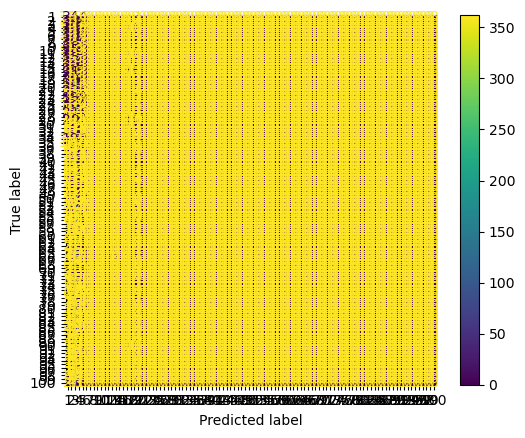

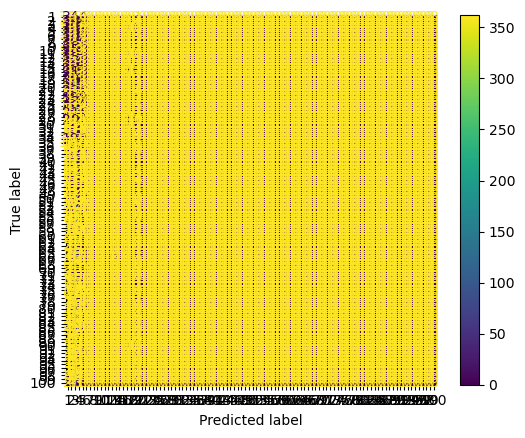

In [23]:
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test).plot()


In [24]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify the new distribution
print(pd.Series(y_resampled).value_counts())


chart_position
86    1589
60    1589
31    1589
45    1589
94    1589
      ... 
84    1589
43    1589
34    1589
87    1589
93    1589
Name: count, Length: 100, dtype: int64


In [25]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

# Verify the new distribution
print(pd.Series(y_resampled).value_counts())


chart_position
1      177
64     177
74     177
73     177
72     177
      ... 
31     177
30     177
29     177
28     177
100    177
Name: count, Length: 100, dtype: int64


## **8. Insights and Visualization**

- **Purpose**:
  - Identify and visualize feature importance.
  - Visualize predicted vs. actual chart position.
  - Visualize correlation between Spotify features and Billboard chart positions.
  - Group songs by playlist_genre and analyze how features vary by genre

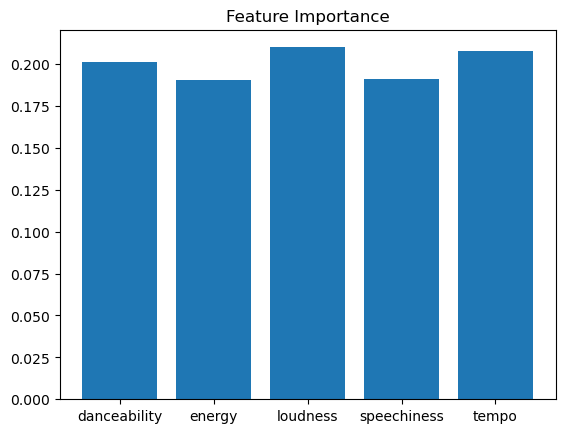

In [27]:
importances = model.feature_importances_
plt.bar(X.columns, importances)
plt.title('Feature Importance')
plt.show()


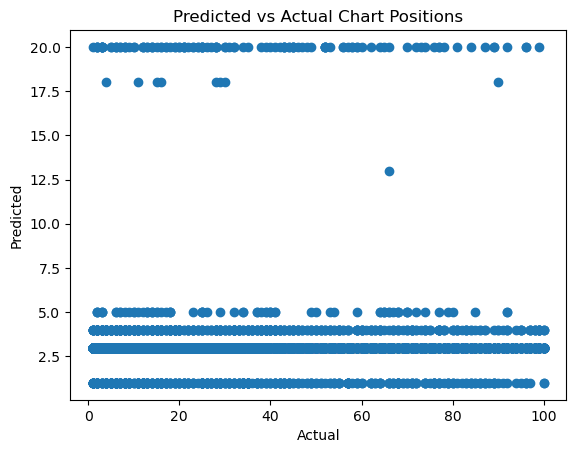

In [28]:
plt.scatter(y_test, y_pred)
plt.title('Predicted vs Actual Chart Positions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


/Users/lisareedpreston/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


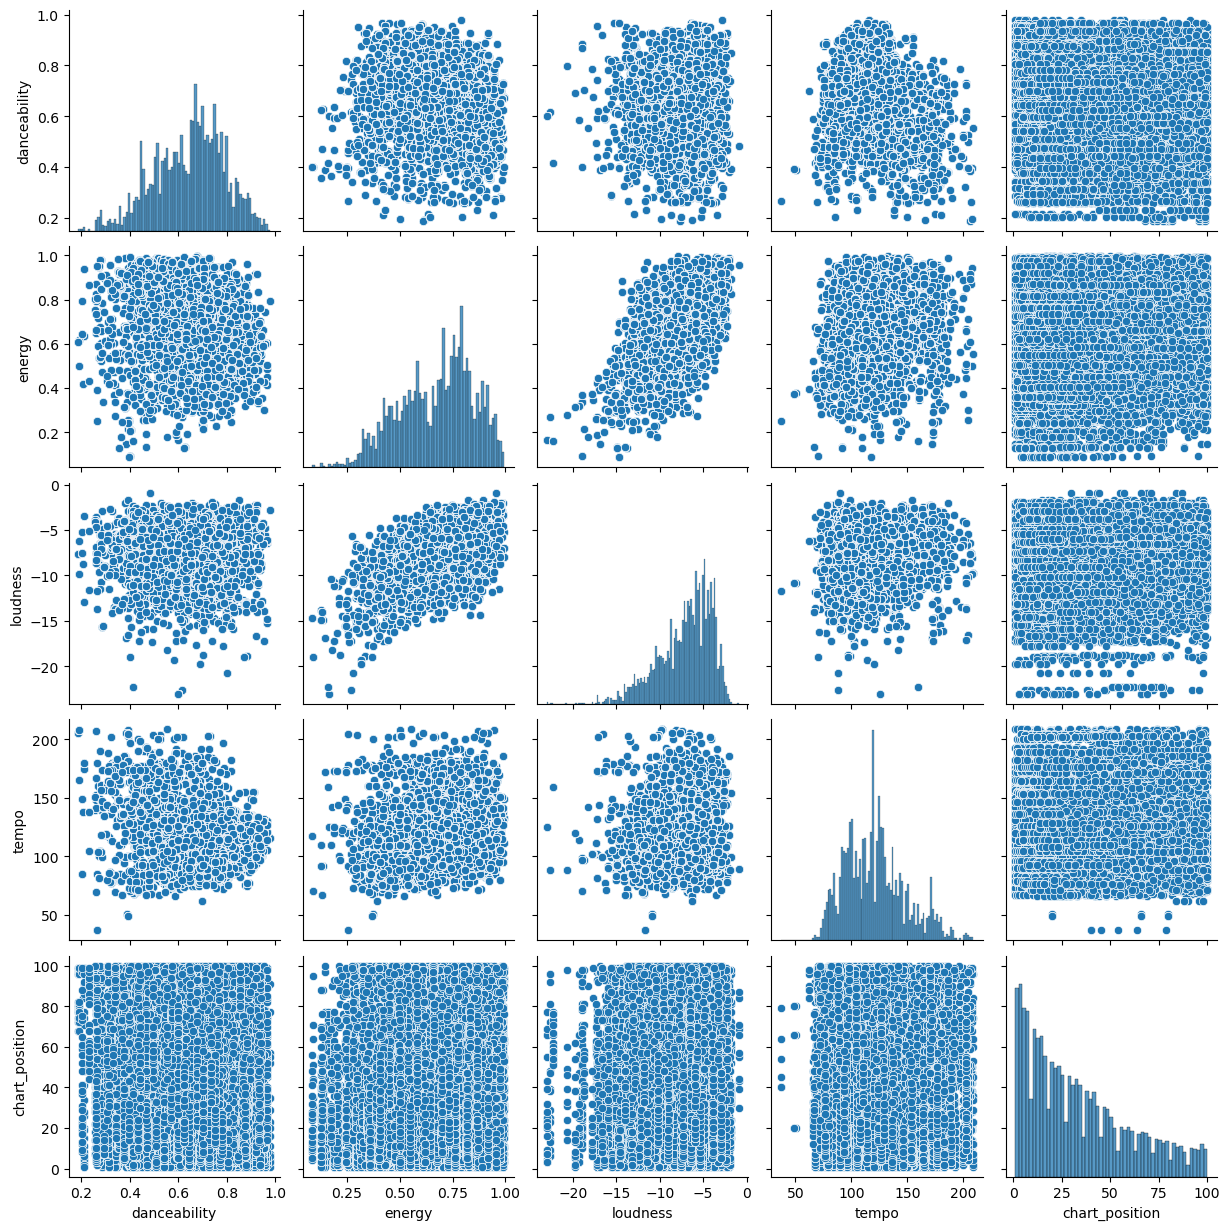

In [29]:
sns.pairplot(merged_df, vars=['danceability', 'energy', 'loudness', 'tempo', 'chart_position'])
plt.show()


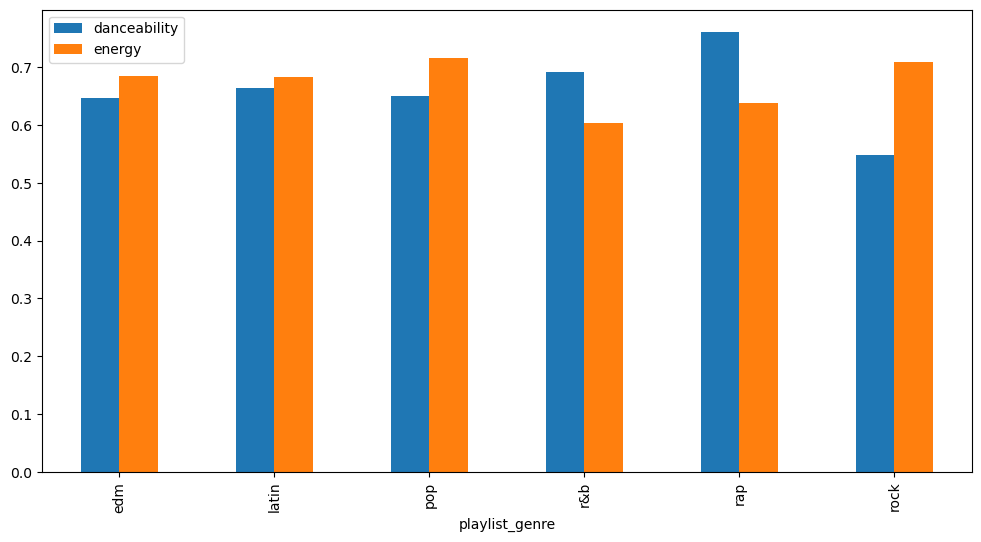

In [30]:
genre_grouped = merged_df.groupby('playlist_genre')[['danceability', 'energy']].mean()
genre_grouped.plot(kind='bar', figsize=(12, 6))
plt.show()


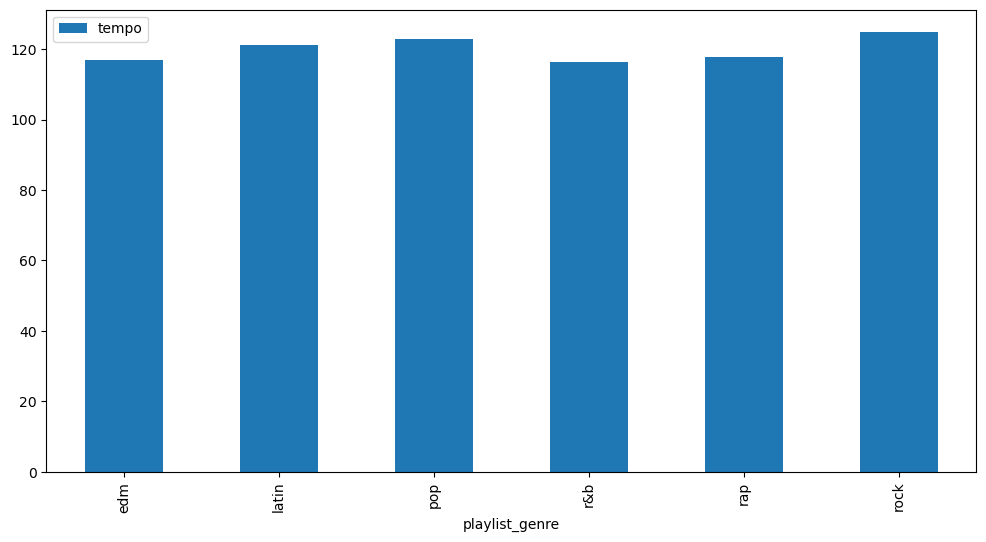

In [31]:
genre_grouped = merged_df.groupby('playlist_genre')[['tempo']].mean()
genre_grouped.plot(kind='bar', figsize=(12, 6))
plt.show()


## **9. Trends and Predictions**

- **Purpose**:
  - Extract chart_date and analyze feature trends over time.
  - Predict top songs 

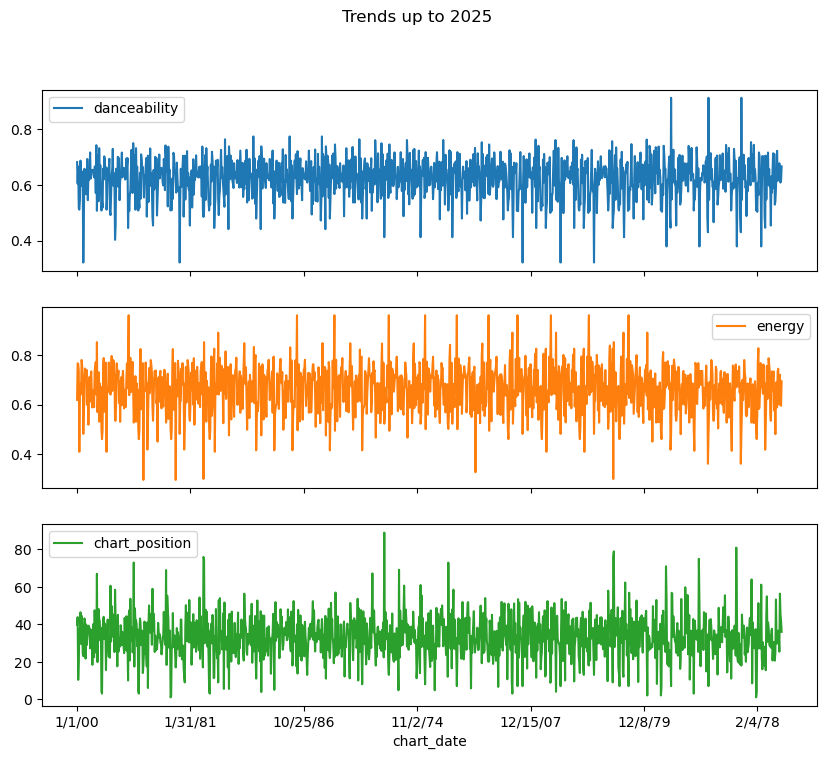

In [32]:
# Filter for rows with a maximum date of 2025
merged_df_max_2025 = merged_df[merged_df['chart_date'] <= '2025-12-31']

# Group by 'chart_date' and calculate the mean for each date
trend_df = merged_df_max_2025.groupby('chart_date')[['danceability', 'energy', 'chart_position']].mean()

# Plot the trends
trend_df.plot(subplots=True, figsize=(10, 8), title="Trends up to 2025")
plt.show()


In [33]:
X = merged_df[['tempo', 'danceability', 'loudness', 'energy']]  # Features
y = merged_df['top_10']  # Target: Top 10 hit or not

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


XGBoost Accuracy: 0.7853264558164789
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     11423
           1       0.55      0.23      0.33      3311

    accuracy                           0.79     14734
   macro avg       0.68      0.59      0.60     14734
weighted avg       0.75      0.79      0.75     14734

XGBoost MAE: 0.2146735441835211
XGBoost RMSE: 0.4633287646839133


## **10. Streamlit App**

- **Purpose**:
  - Interactive app for predicting song popularity based on user-provided features.
  - Uses sliders to input values for `tempo`, `danceability`, `loudness`, and `energy`.

In [35]:
st.title("Song Popularity Predictor")
tempo = st.slider("Tempo", 50, 200, 120)
danceability = st.slider("Danceability", 0.0, 1.0, 0.5)
loudness = st.slider("Loudness", -60, 0, -10)
energy = st.slider("Energy", 0.0, 1.0, 0.5)

if st.button("Predict"):
    model = RandomForestRegressor()  # Load your trained model
    rank = model.predict([[tempo, danceability, loudness, energy]])
    st.write(f"Predicted Billboard Rank: {rank[0]}")

2025-01-26 15:44:29.850 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.916 
  command:

    streamlit run /Users/lisareedpreston/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-01-26 15:44:29.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 15:44:29.920 Thre